# Introduction

The **quantity of CO₂** is determined and described by the chemical term “mole fraction”, defined as the number of carbon dioxide molecules in a given number of molecules of air, after removal of water vapor. For example, 413 parts per million of CO2 (abbreviated as ppm) means that in every million molecules of (dry) air there are on average 413 CO₂ molecules.




In simple terms, **atmospheric CO₂ concentration (in ppm) is the fraction of carbon-dioxide molecules in dry air - one part CO₂ for every one million total air molecules.**

The <u>Global Monitoring Laboratory (**GML**)</u> of the National Oceanic and Atmospheric Administration conducts research on:
 - Greenhouse Gases and Carbon Cycle Feedbacks
 - Changes in Surface Radiation, Clouds, and Aerosols
 - Recovery of Stratospheric Ozone 

All data regarding the Carbon Cycle Greenhouse gasses is taken directly from the Global Monitoring Laboratory, specifically from the Mauna Loa Observatory, Hawaii.
Subsequently, all data is of the same type - <u>in situ samples taken on a daily/weekly basis</u>

The weather data used has been acquired through the Open-Meteo open-source weather API, at the suitable coordinates and chosen time range. 


This research is conducted in order to determine which factors have an effect on CO₂ levels in the environment, as well as assess which ones have the most prominent influence.

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from helpers.helpers import (add_missing_one_year, add_missing_ten_years, 
                     coerce_into_full_datetime, create_heatmaps, 
                     plot_column, plot_entire_df, plot_increase_five_years,
                     summary_stats, plot_rolling_correlations, interpret_p_value,
                     plot_lagged_correlations)
from helpers.helpers import (WeatherPairPlotter, GasDistributionVisualizer)
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

## Importation of Dataset - CO₂ (Carbon Dioxide)

In [2]:
df_station_co2 = pd.read_csv("./data/co2_weekly_mlo.csv")
df_station_co2

,year,month,day,decimal,median_CO2,ndays,1 year ago,10 years ago,increase since 1800
0,1974,5,19,1974.3795,333.37,5,-999.99,-999.99,50.40
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.35,5,-999.99,-999.99,49.60
3,1974,6,9,1974.4370,332.20,7,-999.99,-999.99,49.65
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.06
...,...,...,...,...,...,...,...,...,...
2662,2025,5,25,2025.3959,430.18,5,426.80,403.98,146.94
2663,2025,6,1,2025.4151,429.96,7,427.20,403.37,146.91
2664,2025,6,8,2025.4342,429.93,7,427.25,403.36,147.16
2665,2025,6,15,2025.4534,429.39,6,426.85,402.48,146.99


The initial dataset holds information regarding the CO₂ levels ranging from the year 1974, up to 2025, as well as data on the levels of increase and fequency of measurements. However, the data is severely disorganised and needs cleaing.

# Cleaning and Organizing Data

Checking for invalid data:

In [3]:
invalid_average = (df_station_co2['median_CO2'] == -999.99).sum()
invalid_1year = (df_station_co2['1 year ago'] == -999.99).sum()
invalid_10years = (df_station_co2['10 years ago'] == -999.99).sum()

print(invalid_average)
print(invalid_1year)
print(invalid_10years)

18
70
540


The information from the other columns can be used to create a valid datetime format.

The 'decimal' column along with the 'day' and 'month' columns can be used to adjust the datetime index accordingly

In [4]:
df_station_co2['year'] = df_station_co2['year'].astype(str).str.strip()
mask = df_station_co2['year'] == 'year'
df_station_co2.loc[mask, 'year'] = df_station_co2.loc[mask, 'decimal'].fillna(0).apply(lambda x: int(float(x)))

In [5]:
df_station_co2.drop(columns = ['decimal'], inplace = True)
df_station_co2 = coerce_into_full_datetime(df_station_co2)

In [6]:
df_station_co2

,median_CO2,ndays,1 year ago,10 years ago,increase since 1800
datetime,,,,,
1974-05-19,333.37,5,-999.99,-999.99,50.40
1974-05-26,332.95,6,-999.99,-999.99,50.06
1974-06-02,332.35,5,-999.99,-999.99,49.60
1974-06-09,332.20,7,-999.99,-999.99,49.65
1974-06-16,332.37,7,-999.99,-999.99,50.06
...,...,...,...,...,...
2025-05-25,430.18,5,426.80,403.98,146.94
2025-06-01,429.96,7,427.20,403.37,146.91
2025-06-08,429.93,7,427.25,403.36,147.16


The data from the '`1 year ago`' and '`10 years ago`' columns is used to include and adjust missing datetimes, thus giving a richer dataframe which would allow us to capture the trend effectively. 

In [7]:
df_station_co2 = add_missing_ten_years(df_station_co2) # using the function to create new rows using the '10 year ago' column
df_station_co2 = add_missing_one_year(df_station_co2) # using the function to create new rows using the '1 year ago' column
df_station_co2.drop(df_station_co2[df_station_co2['median_CO2'] == -999.99].index, inplace=True)

In [8]:
df_station_co2

,median_CO2,ndays,1 year ago,10 years ago,increase since 1800
1974-05-19,333.37,5.0,-999.99,-999.99,50.40
1974-05-25,332.95,NaN,NaN,NaN,NaN
1974-05-26,332.95,6.0,-999.99,-999.99,50.06
1974-06-01,332.44,NaN,NaN,NaN,NaN
1974-06-02,332.35,5.0,-999.99,-999.99,49.60
...,...,...,...,...,...
2025-05-25,430.18,5.0,426.80,403.98,146.94
2025-06-01,429.96,7.0,427.20,403.37,146.91
2025-06-08,429.93,7.0,427.25,403.36,147.16
2025-06-15,429.39,6.0,426.85,402.48,146.99


## Importation and Cleaning - N₂O (Nitrous Oxide)

In [9]:
df_N2O = pd.read_csv('./data/n2o_daily_mlo.csv')

new_column_names = ['year', 'month', 'day', 'median_N2O', 'std._dev.N2O', 'samplesN2O']
df_N2O.columns = new_column_names
df_N2O.drop(columns=["std._dev.N2O", "samplesN2O"], inplace=True)

df_N2O

,year,month,day,median_N2O
0,1998,11,28,NaN
1,1998,11,29,NaN
2,1998,11,30,NaN
3,1998,12,1,NaN
4,1998,12,2,NaN
...,...,...,...,...
8760,2022,11,23,337.97
8761,2022,11,24,337.61
8762,2022,11,25,337.51
8763,2022,11,26,337.02


The dataset contains disorganised information on the levels of N₂O, ranging from 1998 to 2022.

In [10]:
df_N2O = coerce_into_full_datetime(df_N2O)
df_N2O

,median_N2O
datetime,
1998-11-28,NaN
1998-11-29,NaN
1998-11-30,NaN
1998-12-01,NaN
1998-12-02,NaN
...,...
2022-11-23,337.97
2022-11-24,337.61
2022-11-25,337.51


In [11]:
invalid_median = (df_N2O['median_N2O'].isna()).sum()

print(invalid_median)

974


In [12]:
df_N2O.interpolate(method='time', inplace=True)
df_N2O.fillna(method='ffill', inplace=True)
df_N2O.fillna(method='bfill', inplace=True)

# Removing outliers
z_scores = np.abs(zscore(df_N2O['median_N2O']))
df_N2O = df_N2O[z_scores < 3]

df_N2O

,median_N2O
datetime,
1998-11-28,315.59
1998-11-29,315.59
1998-11-30,315.59
1998-12-01,315.59
1998-12-02,315.59
...,...
2022-11-23,337.97
2022-11-24,337.61
2022-11-25,337.51


Different types of interpolation have provided the same results regarding the missing values, however the number of rows affected is relatively small in comparison to the entire dataset. Since the dataset is smaller by itself, regular interpolation and filling is used in order to avoid unnecessary loss of data. 

In [13]:
invalid_median = (df_N2O['median_N2O'].isna()).sum()
print(invalid_median)

0


## Importation and Cleaing - CH<sub>4</sub> (Methane) 

In [14]:
df_CH4 = pd.read_csv("./data/ch4_daily_mlo.csv")

In [15]:

new_column_names = [
    "site_code", "year", "month", "day", "hour", "minute", "second",
    "datetime", "time_decimal", "midpoint_time", "median_CH4", "value_std_dev_CH4",
    "nvalue_CH4", "latitude", "longitude", "altitude", "elevation", "intake_height", "qcflag"
]

df_CH4.columns = new_column_names

df_CH4.drop(
    columns=["site_code", "year", "month", "day", "hour", "minute", "second", "time_decimal",
             "midpoint_time", "latitude", "longitude", "altitude", "elevation", "intake_height", "qcflag"],
    inplace=True
)
df_CH4["datetime"] = pd.to_datetime(df_CH4["datetime"]).dt.date
df_CH4.set_index("datetime", inplace=True)

df_CH4


,median_CH4,value_std_dev_CH4,nvalue_CH4
datetime,,,
1987-01-02,-999.99,-99.99,0
1987-01-03,-999.99,-99.99,0
1987-01-04,-999.99,-99.99,0
1987-01-05,-999.99,-99.99,0
1987-01-06,-999.99,-99.99,0
...,...,...,...
2024-04-26,1977.78,0.85,7
2024-04-27,1969.78,2.95,7
2024-04-28,1955.87,7.38,7


The dataset contains disorganised data on CH<sub>4</sub> levels ranging from 1987 to 2024.

In [16]:
invalid_CH4 = (df_CH4['median_CH4'] == -999.99).sum()
invalid_CH4

906

Since the invalid rows in this dataset are of a miniscule amount in comparison to the size of the whole data, completely removing them does no harm. 

In [17]:
df_CH4 = df_CH4.loc[df_CH4["median_CH4"] != -999.99]


# Removing outliers
z_scores = np.abs(zscore(df_CH4['median_CH4']))

df_CH4 = df_CH4[z_scores < 3]

In [18]:
invalid_CH4 = (df_CH4['median_CH4'] == -999.99).sum()
invalid_CH4

0

## Importation and Cleaning - SF<sub>6</sub> (Sulfur Hexafluoride)

In [19]:
df_SF6 = pd.read_csv("./data/sf6_daily_mlo.csv", skiprows=1)

new_column_names = ['year', 'month', 'day', 'median_SF6', 'std._dev.SF6', 'samplesSF6']
df_SF6.columns = new_column_names

df_SF6.drop(columns=["std._dev.SF6", "samplesSF6"], inplace=True)

In [20]:
df_SF6['year'] = df_SF6['year'].astype(str).str.strip()
mask = df_SF6['year'] == 'year'

df_SF6 = coerce_into_full_datetime(df_SF6) # using the `year`, `month` and `day` columns
df_SF6

,median_SF6
datetime,
1998-11-29,NaN
1998-11-30,NaN
1998-12-01,NaN
1998-12-02,NaN
1998-12-03,NaN
...,...
2022-11-23,11.594
2022-11-24,11.518
2022-11-25,11.455


The dataset contains disorganised data on SF<sub>6</sub> levels ranging from 1998 to 2022

In [21]:
invalid_median = (df_SF6['median_SF6'].isna()).sum()

print(invalid_median)

1069


In [22]:
df_SF6.interpolate(method='time', inplace=True)
df_SF6.fillna(method='ffill', inplace=True)
df_SF6.fillna(method='bfill', inplace=True)

# Removing outliers
z_scores = np.abs(zscore(df_SF6['median_SF6']))
df_SF6 = df_SF6[z_scores < 3]

df_SF6

,median_SF6
datetime,
1998-11-29,4.351
1998-11-30,4.351
1998-12-01,4.351
1998-12-02,4.351
1998-12-03,4.351
...,...
2022-11-23,11.594
2022-11-24,11.518
2022-11-25,11.455


The same interpolation method is used as before, for the same reasons.

In [23]:
invalid_median = (df_SF6['median_SF6'].isna()).sum()

print(invalid_median)

0


## Merging and Organising Greenhouse Gasses dataframes

In [23]:
dfs = [df.copy() for df in [df_station_co2, df_N2O, df_CH4, df_SF6]]
for i in range(len(dfs)):
    dfs[i].index = pd.to_datetime(dfs[i].index)  # Converting index to proper datetime64[ns]

start_date = df_station_co2.index.min()  # Get the earliest date from df_CO2_meteo
dfs = [df[df.index >= start_date] for df in dfs]

df_combined_gasses = pd.concat(
    [
        dfs[0][["median_CO2"]],
        dfs[1][["median_N2O"]],
        dfs[2][["median_CH4"]],
        dfs[3][["median_SF6"]],
    ],
    axis=1,
    join="inner"
)


In [24]:
df_combined_gasses

,median_CO2,median_N2O,median_CH4,median_SF6
1998-11-29,366.74,315.59,1803.06,4.351
1998-12-12,367.20,315.59,1799.96,4.351
1998-12-13,367.32,315.59,1800.91,4.351
1998-12-19,367.48,315.59,1799.07,4.351
1998-12-20,367.44,315.59,1807.50,4.351
...,...,...,...,...
2022-11-13,417.25,337.65,1951.90,11.413
2022-11-19,418.38,337.01,1948.15,11.305
2022-11-20,418.48,337.93,1958.26,11.425
2022-11-26,417.81,337.02,1954.00,11.394


### Merging and Organising CO2 with Weather data

In [25]:
df_weather = pd.read_csv('./data/open_meteo_weather_API.csv', skiprows=3)
df_weather.index = pd.to_datetime(df_weather.index).strftime('%Y-%m-%d %H:%M:%S')
df_weather.reset_index(inplace=True)
df_weather.set_index('time', inplace=True)
df_weather.drop(columns = 'index', inplace = True)
df_weather.index = pd.to_datetime(df_weather.index)
df_weather = df_weather.resample('D').mean()

In [26]:
df_weather

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),pressure_msl (hPa),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),soil_temperature_0_to_7cm (°C),surface_pressure (hPa)
time,,,,,,,,,
1974-05-01,26.391667,78.666667,22.375000,0.000000,1013.758333,0.227917,32.920833,26.700000,1013.758333
1974-05-02,26.612500,78.500000,22.570833,0.000000,1014.570833,0.227500,28.279167,26.933333,1014.570833
1974-05-03,26.275000,78.625000,22.258333,0.020833,1014.241667,0.226250,22.037500,27.066667,1014.241667
1974-05-04,26.266667,82.041667,22.929167,0.041667,1013.062500,0.197500,22.354167,27.300000,1013.062500
1974-05-05,26.454167,84.375000,23.629167,0.050000,1014.145833,0.197917,25.895833,27.466667,1014.145833
...,...,...,...,...,...,...,...,...,...
2025-06-21,26.516667,82.750000,23.304167,0.758333,1014.062500,0.123750,21.395833,29.095833,1014.062500
2025-06-22,27.600000,77.791667,23.320833,0.241667,1013.891667,0.187083,21.125000,29.000000,1013.891667
2025-06-23,28.125000,76.458333,23.570833,0.054167,1013.858333,0.243333,24.237500,29.020833,1013.858333


In [27]:
# Creating df on dates when station data and Open Meteo data overlap
common_dates = df_weather.index.intersection(df_station_co2.index)
df_weather = df_weather.loc[common_dates]

# Merging
df_station_column = df_station_co2[['median_CO2']]
df_CO2_meteo = df_weather.join(df_station_column, how='inner')

In [28]:
df_CO2_meteo.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'precipitation (mm)', 'pressure_msl (hPa)',
       'et0_fao_evapotranspiration (mm)', 'wind_speed_10m (km/h)',
       'soil_temperature_0_to_7cm (°C)', 'surface_pressure (hPa)',
       'median_CO2'],
      dtype='object')

# Visualisations

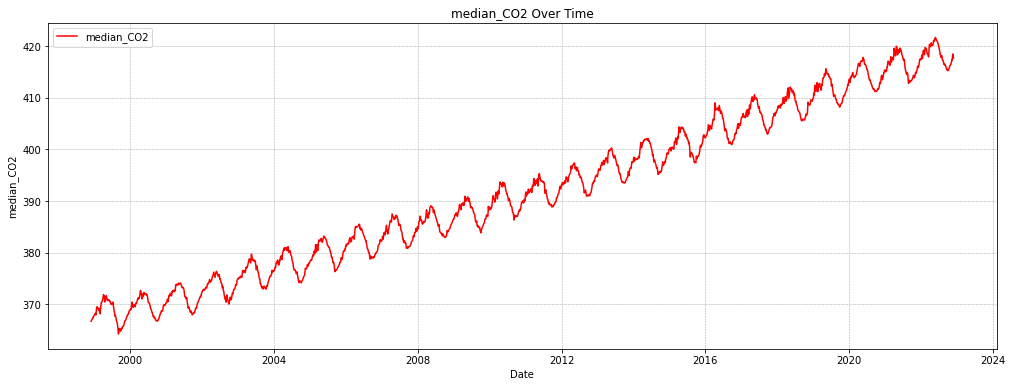

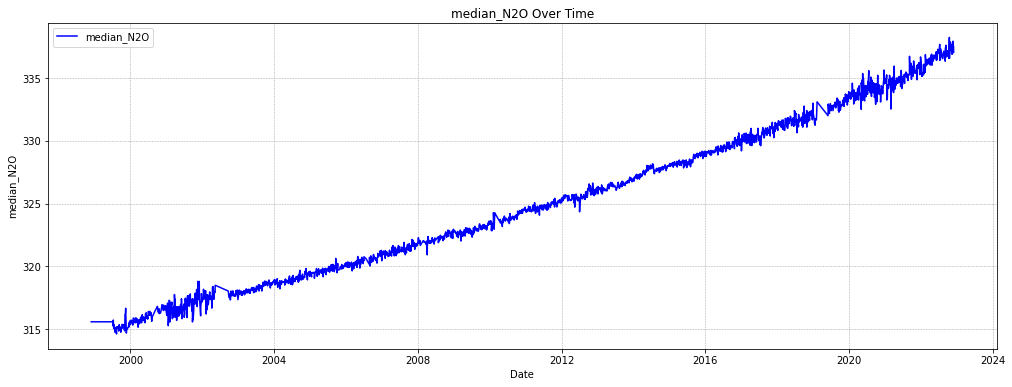

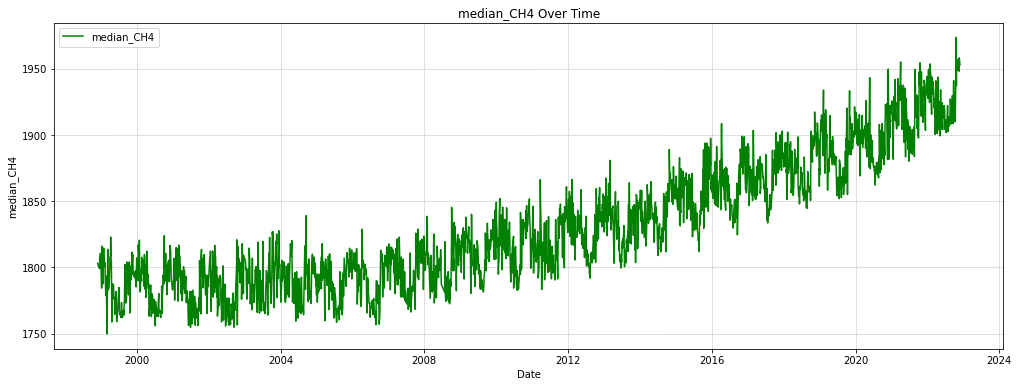

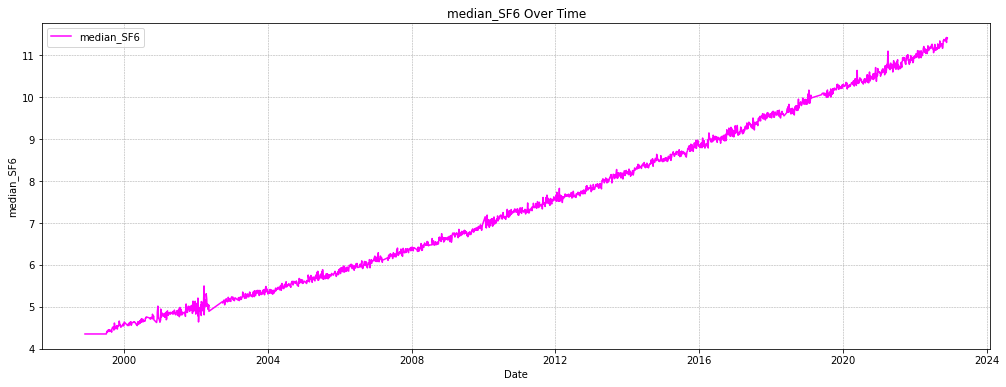

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [29]:
plot_column(df_combined_gasses, 'median_CO2', 'red')
plot_column(df_combined_gasses, 'median_N2O', 'blue')
plot_column(df_combined_gasses, 'median_CH4', 'green')
plot_column(df_combined_gasses, 'median_SF6', 'magenta')
plt.tight_layout

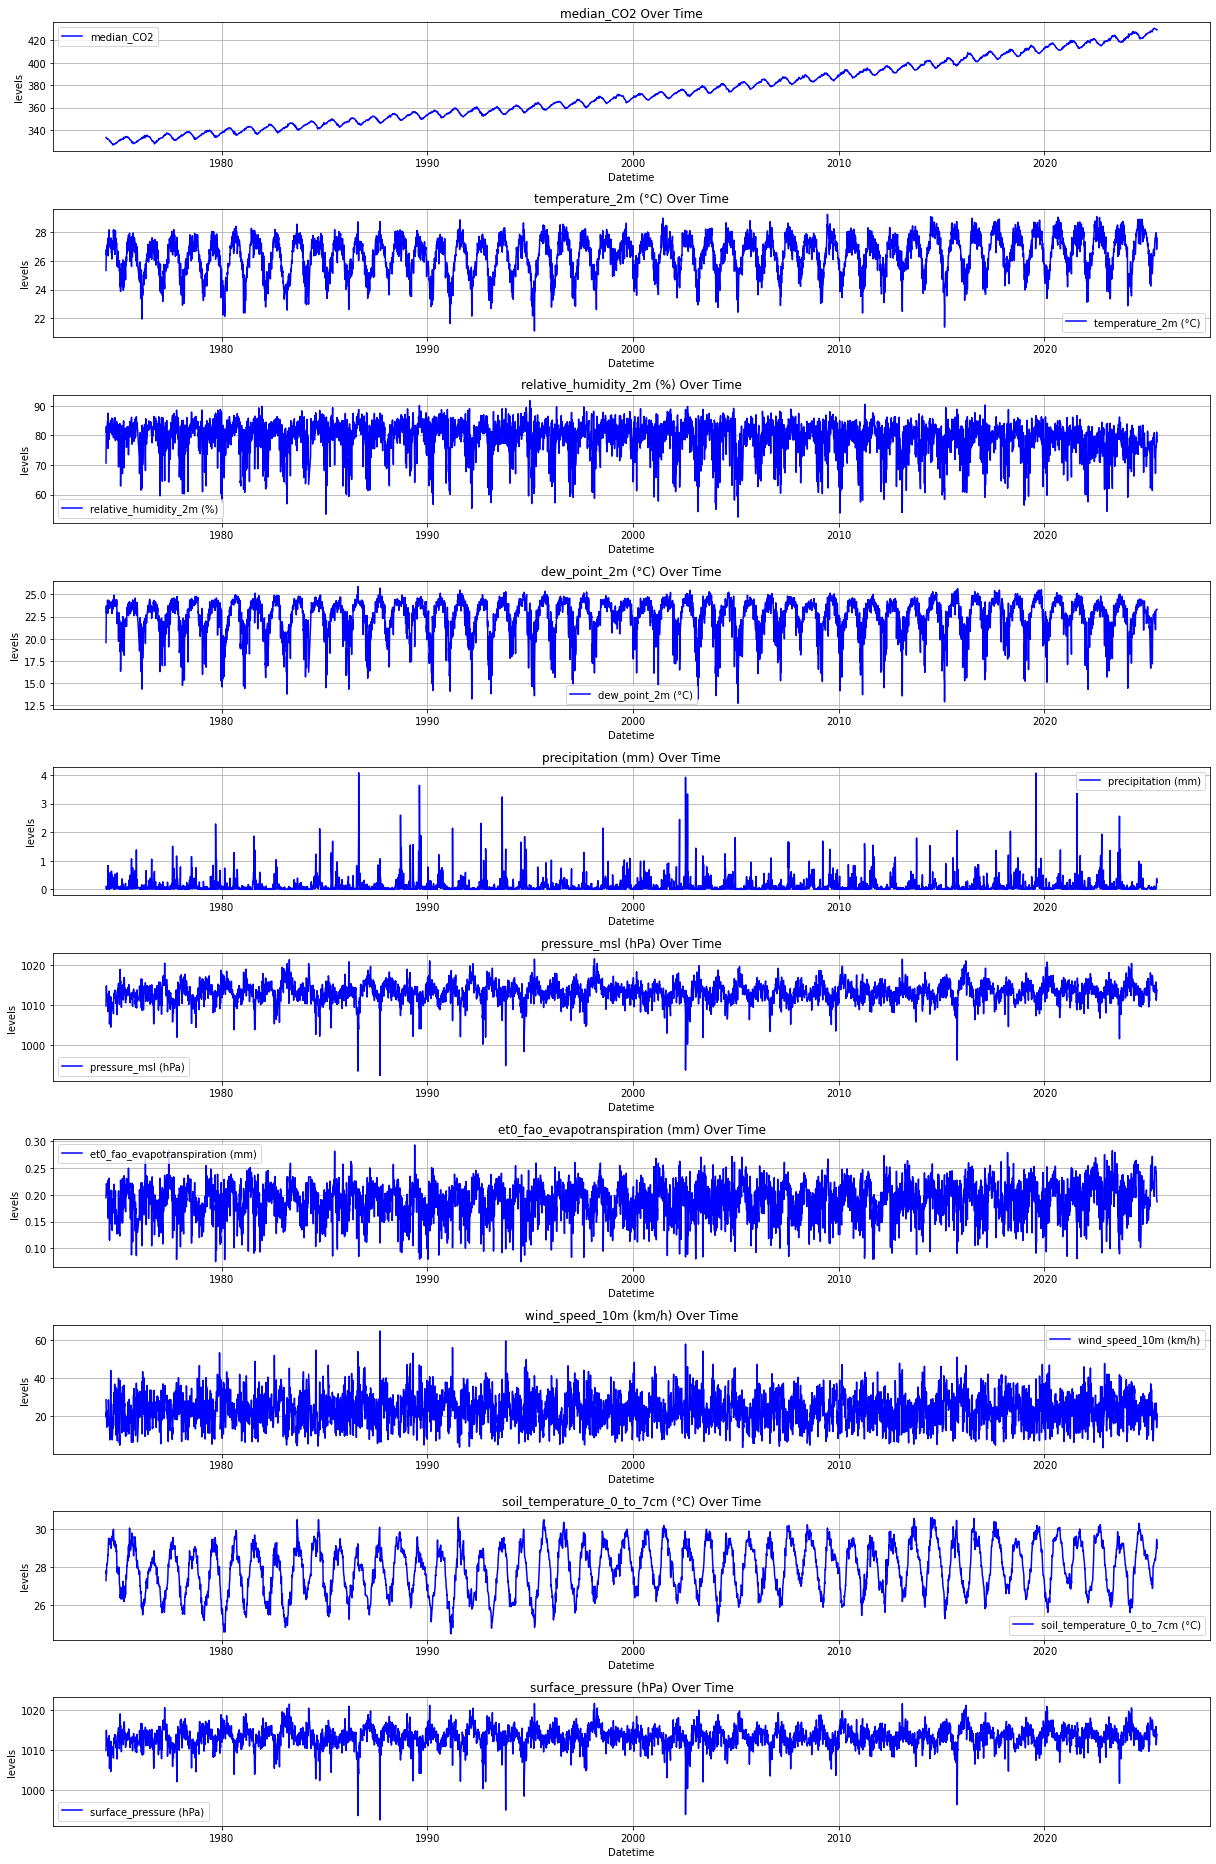

In [30]:
plot_entire_df(df_CO2_meteo)

The visualisations, in both datasets clearly depicts the seasonal trends. 

Outliers in the weather dataset were not removed, as there are numerous natural reasons for sudden spikes or drops in most variables.

# Analysis

## Descriptive Analysis

### CO<sub>2</sub> and Greenhouse Gasses

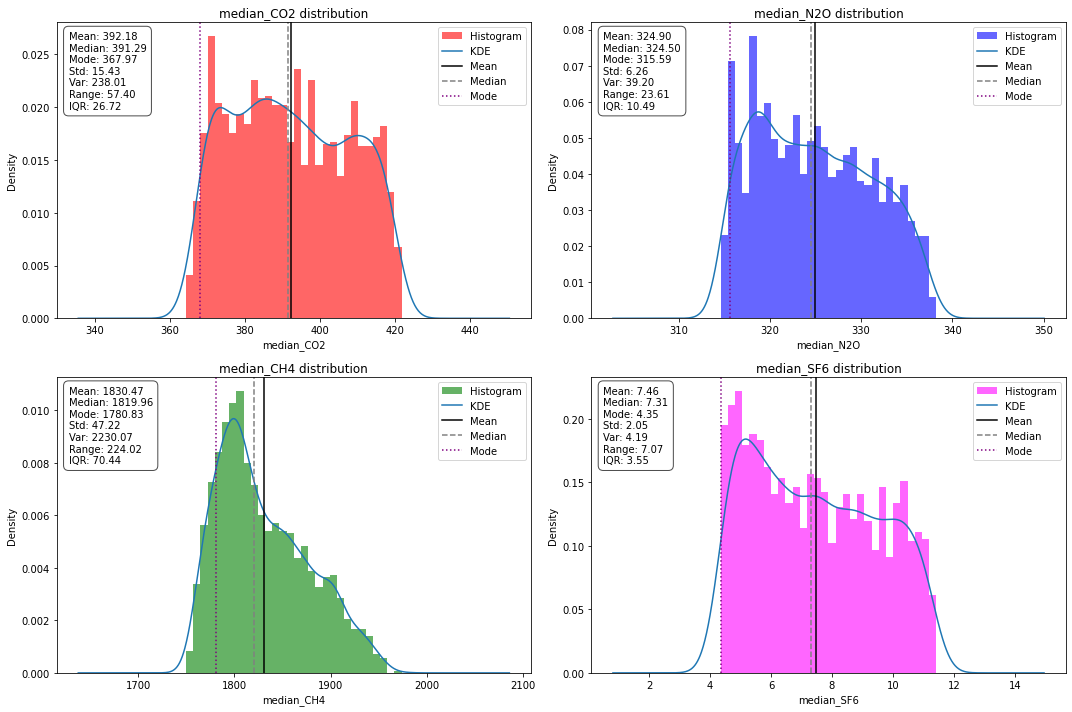

In [31]:
visualizer = GasDistributionVisualizer(df_combined_gasses, summary_stats(df_combined_gasses))
visualizer.visualize()  

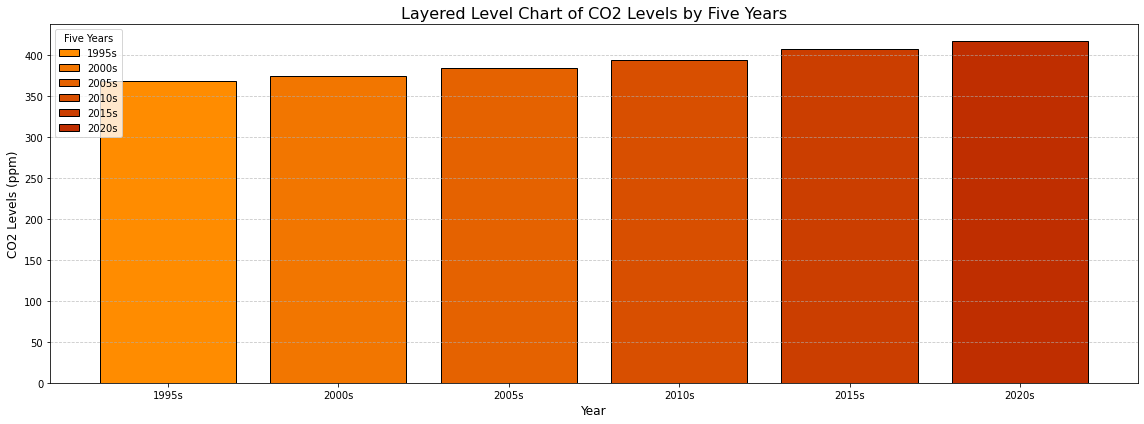

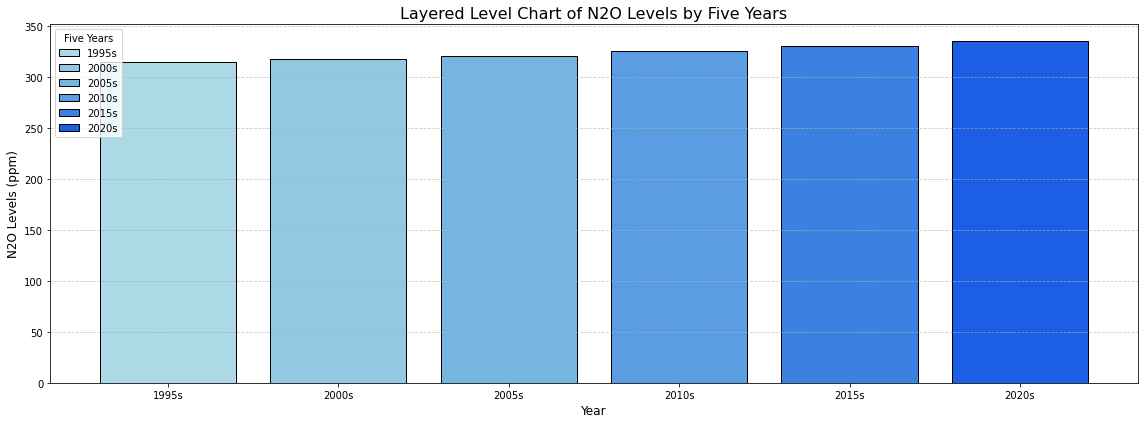

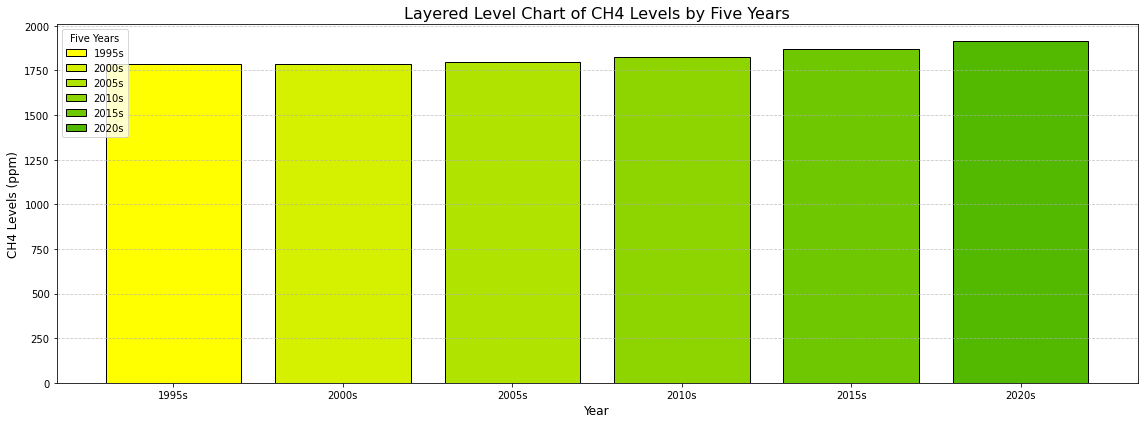

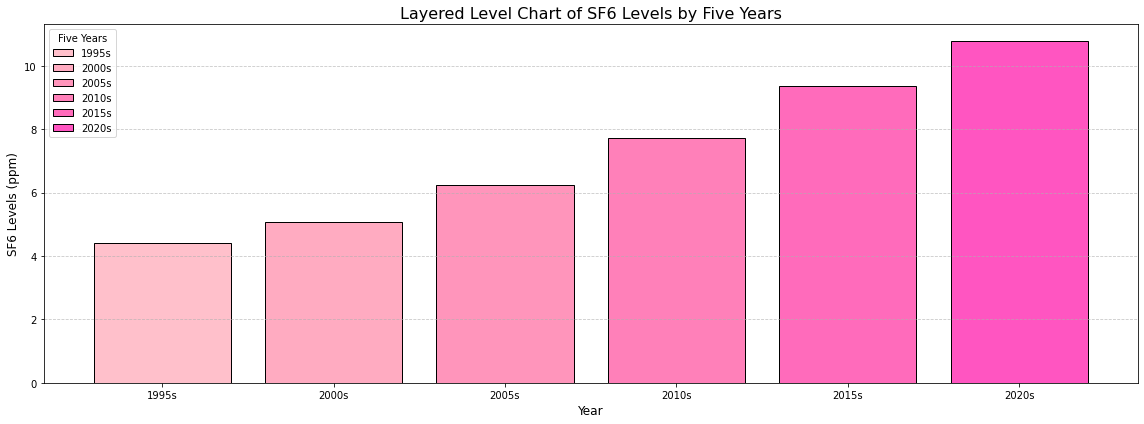

In [32]:
plot_increase_five_years(df_combined_gasses, "median_CO2", "CO2", "darkorange", 'darkred')
plot_increase_five_years(df_combined_gasses, "median_N2O", "N2O", "lightblue", "darkblue")
plot_increase_five_years(df_combined_gasses, "median_CH4", "CH4", "yellow", "green")
plot_increase_five_years(df_combined_gasses, "median_SF6", "SF6", "pink", "magenta")

The visualisations show clear increase of gas concentration over time.

### CO<sub>2</sub> and Weather Variables

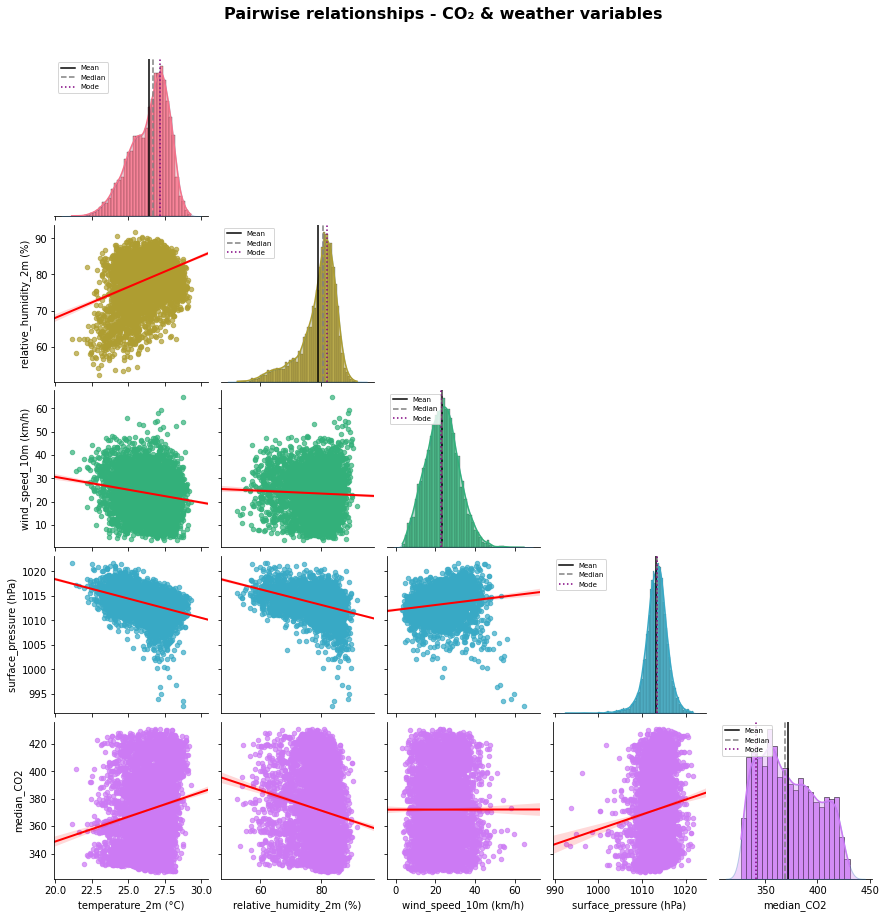

In [33]:
selected_cols = [
    "temperature_2m (°C)",
    "relative_humidity_2m (%)",
    "wind_speed_10m (km/h)",
    "surface_pressure (hPa)",
    "median_CO2"
]

plotter = WeatherPairPlotter(
    df_CO2_meteo,
    selected_cols,
    "Pairwise relationships - CO₂ & weather variables"
)

plotter.create_pairplot()
plotter.show()

In [34]:
summary_stats(df_weather)

,column,mean,median,mode,std,var,range,IQR
0,temperature_2m (°C),26.440551,26.695833,27.170833,1.289433,1.662639,8.154167,1.853125
1,relative_humidity_2m (%),79.017593,80.500000,82.041667,5.989612,35.875452,39.375000,6.489583
2,dew_point_2m (°C),22.450477,23.075000,24.079167,2.123801,4.510530,13.150000,2.498958
3,precipitation (mm),0.122877,0.033333,0.000000,0.273434,0.074766,4.079167,0.112500
4,pressure_msl (hPa),1013.277113,1013.412500,1013.320833,2.545035,6.477205,29.137500,2.873958
5,et0_fao_evapotranspiration (mm),0.188450,0.192083,0.175000,0.033404,0.001116,0.217917,0.045000
6,wind_speed_10m (km/h),23.522957,23.489583,22.804167,8.288643,68.701596,61.375000,11.064583
7,soil_temperature_0_to_7cm (°C),27.951299,28.033333,29.000000,1.268068,1.607996,6.133333,2.100000
8,surface_pressure (hPa),1013.277113,1013.412500,1013.320833,2.545035,6.477205,29.137500,2.873958


Since CO₂ is the target of interest, plotting all columns would flood the grid, making patterns hard to see.

Temperature, humidity, wind speed and surface pressure are the four classic meteorological drivers most often linked to CO₂ variability, therefore a pairplot provides a clear, representative snapshot without overcrowding the visual.

## Correlation Analysis

### Correlation Analysis - CO<sub>2</sub> and Weather variables

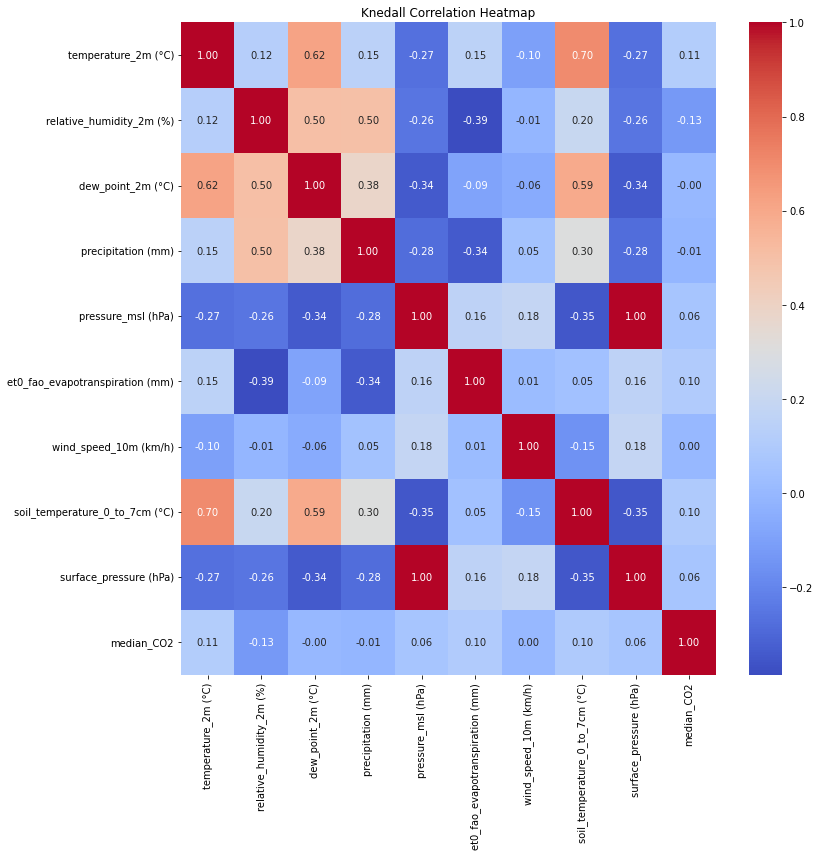

In [35]:
# Computing Kendall's Tau correlation matrix
kendall_corr = df_CO2_meteo.corr(method='kendall')

create_heatmaps((kendall_corr, "Knedall Correlation Heatmap"))

Surprisingly and unfortunately, there seems to be little to no correlation between the weather data and the average levels of CO2 at this particular location.

However further testing and assessment is needed before drawing final conclusions.

The heatmap shows that *surface\_pressure* and *pressure\_msi* have identical values. To avoid redundancy, *surface\_pressure* was removed.

In [36]:
df_CO2_meteo.drop(['surface_pressure (hPa)'],axis=1,inplace = True)

In [37]:
df_CO2_meteo.rename(columns={'average': 'average_CO2', 'temperature_2m (°C)' : 'temperature', 
                             'relative_humidity_2m (%)':'humidity', 'dew_point_2m (°C)' : 'dew_point',
                             'precipitation (mm)' : 'precipitation', 'pressure_msl (hPa)' : 'pressure',
                             'et0_fao_evapotranspiration (mm)' : 'evapotranspiration', 
                             'wind_speed_10m (km/h)' : 'wind_speed', 'soil_temperature_0_to_7cm (°C)' : 'soil_temperature'}, inplace=True)

In [38]:
df_CO2_meteo.to_csv('./data/df_CO2_meteo.csv', index=True)

### Correlation Analysis - CO<sub>2</sub>, Greenhouse Gasses and Weather Variables

In [39]:
df_combined_inner = pd.concat(
    [df_CO2_meteo[['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
             'evapotranspiration', 'wind_speed', 'soil_temperature']],
     df_combined_gasses[['median_CO2', 'median_N2O', 'median_CH4', 'median_SF6']]],
    axis=1, join="inner")

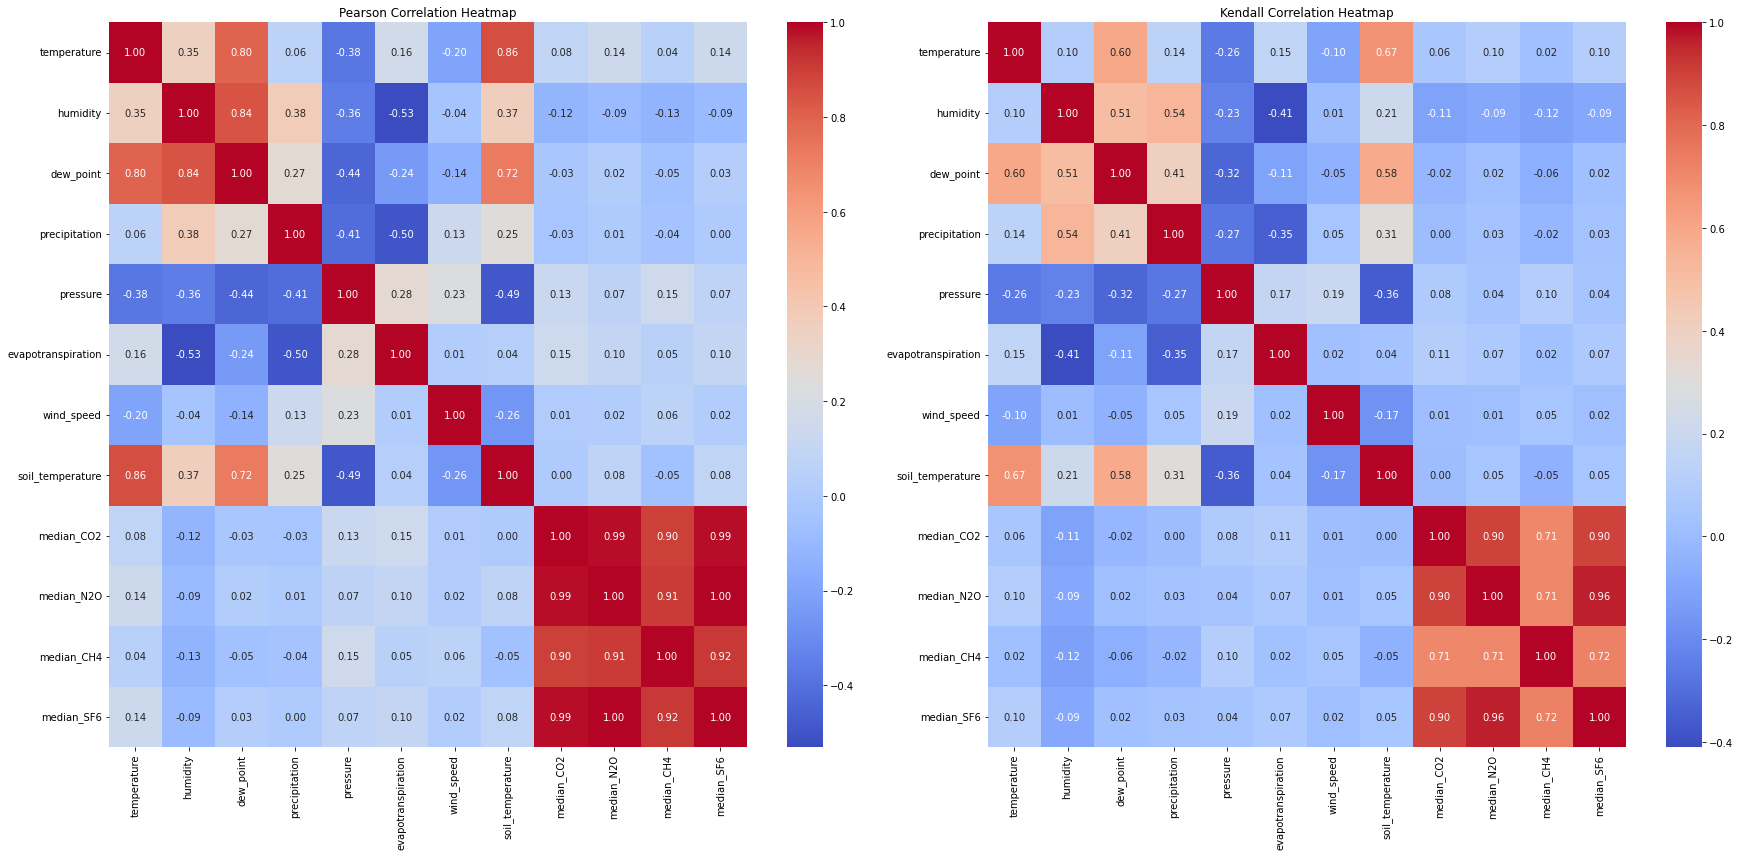

In [40]:
# Computing Pearson correlation matrix
pearson_corr = df_combined_inner.corr(method='pearson')

# Computing Kendall's Tau correlation matrix
kendall_corr = df_combined_inner.corr(method='kendall')

create_heatmaps(
                (pearson_corr, "Pearson Correlation Heatmap"),
                (kendall_corr, "Kendall Correlation Heatmap")
)

**Pearson's correlation** measures the linear relationship between variables.

The correlation coefficient ranges from -1 to +1, where -1 indicates a perfect negative linear relationship, +1 indicates a perfect positive linear relationship, and 0 indicates no linear relationship.

However, it has a limitation: it only captures linear relationships and can miss other types of relationships between variables.

**Kendall's Tau** takes a different approach. Instead of measuring linear relationships, it looks at the concordance between variables - essentially, whether they tend to move in the same direction. It's measuring the tendency of the variables to increase or decrease together, without assuming anything about the shape of that relationship.

In the context of environmental data like CO2 levels, temperature, and other climate variables, Kendall's Tau might be particularly useful because environmental relationships aren't always linear, and the data often contains outliers or follows non-normal distributions.

### Rolling Correlations

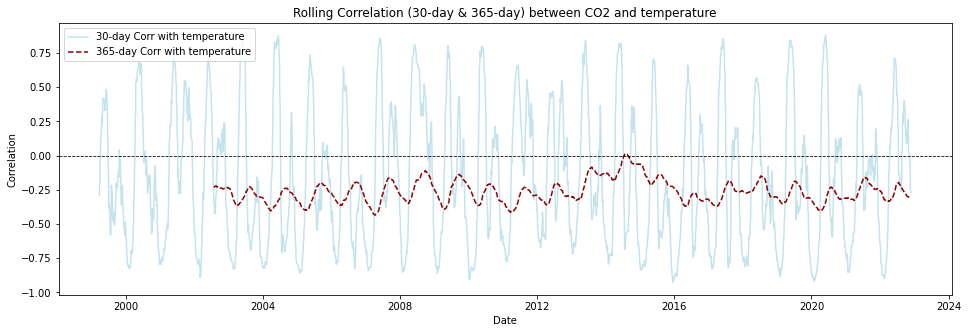

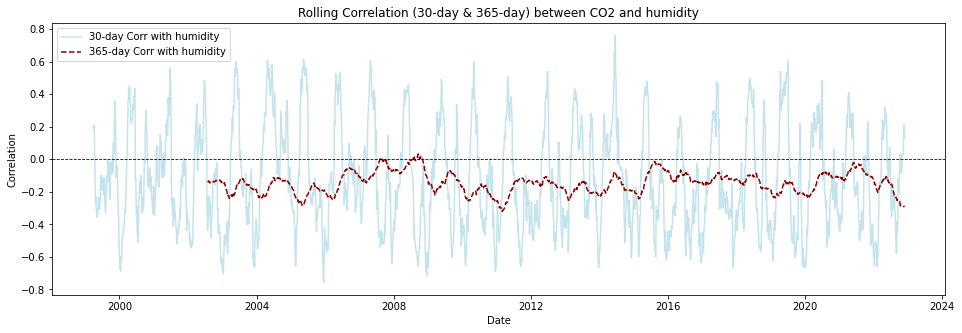

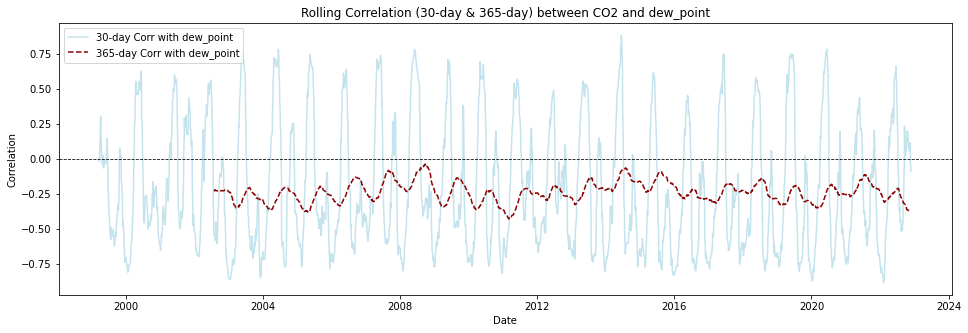

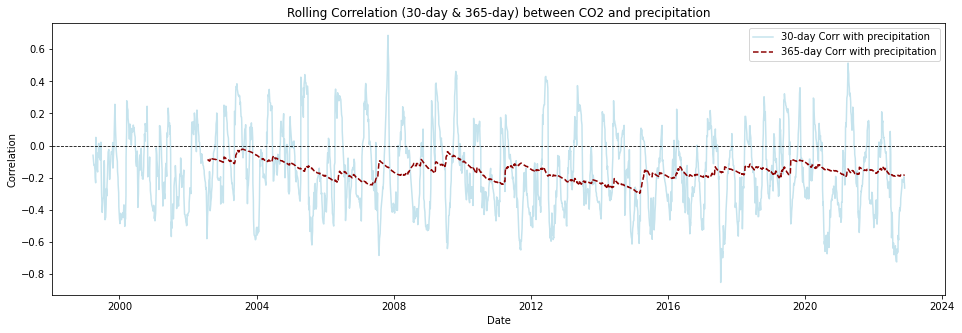

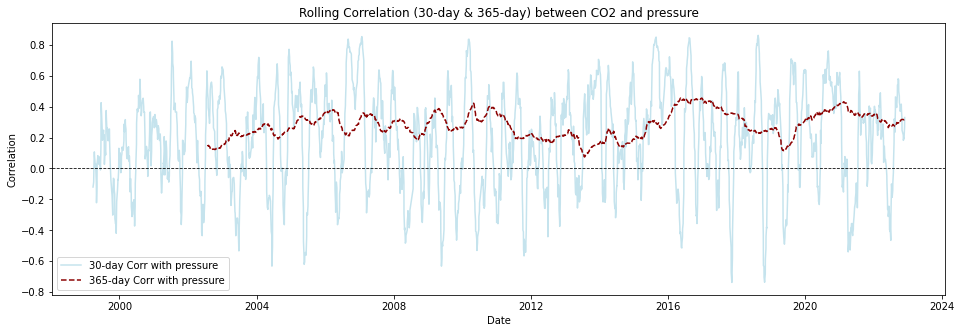

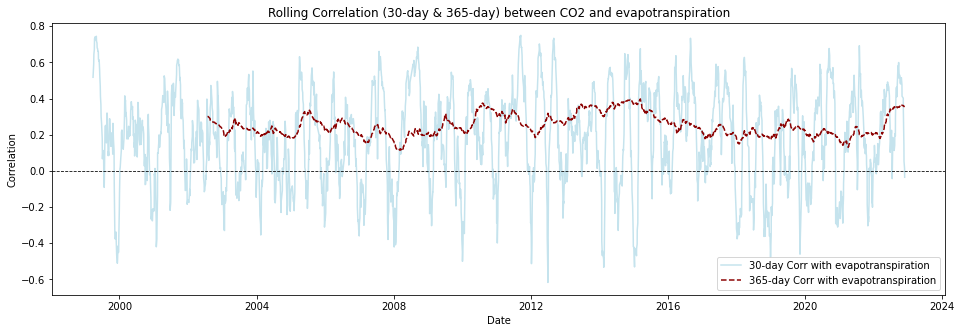

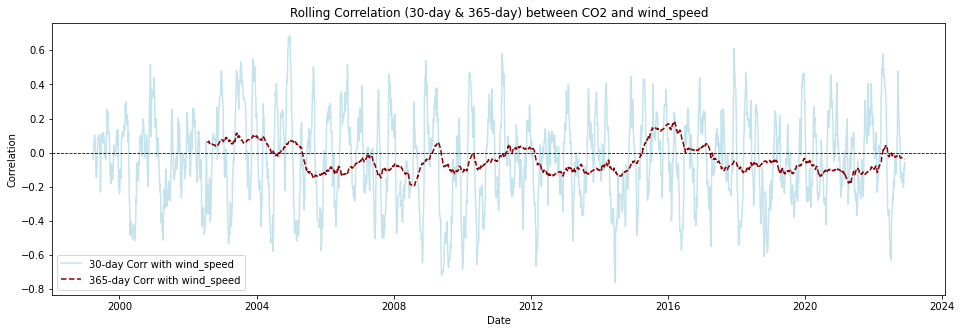

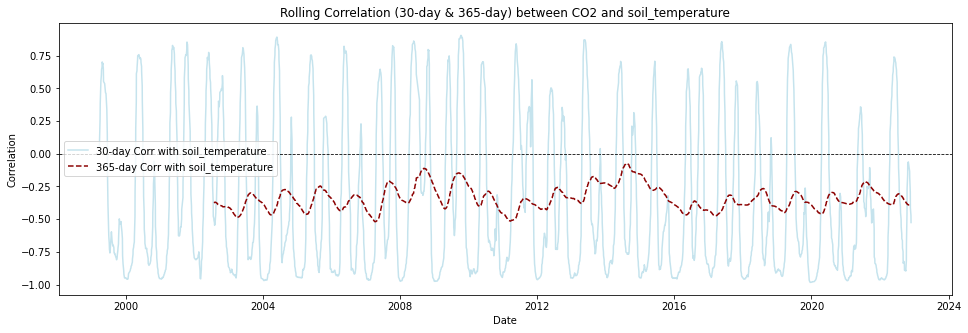

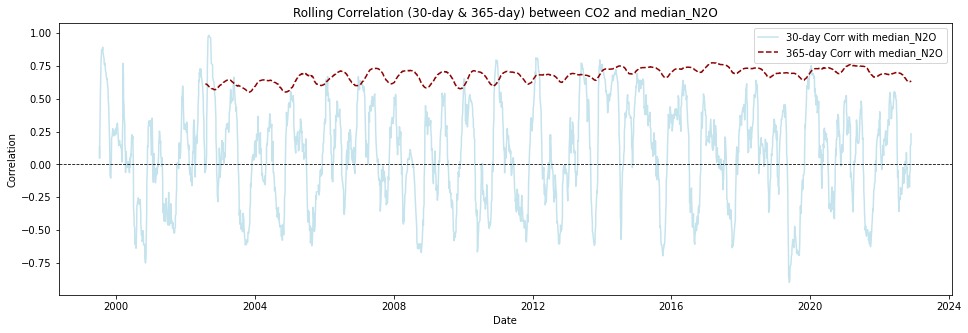

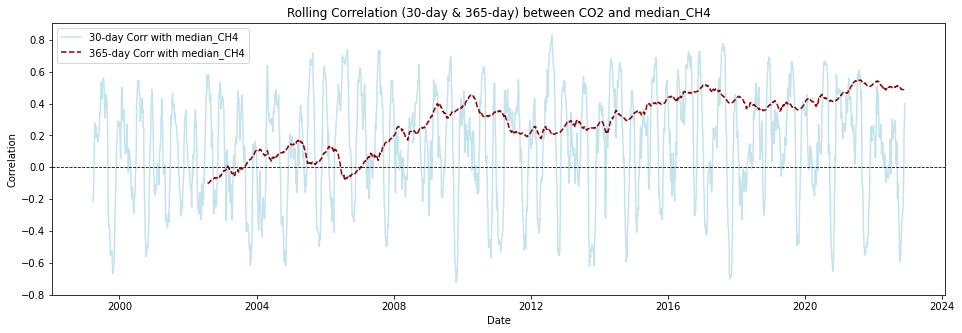

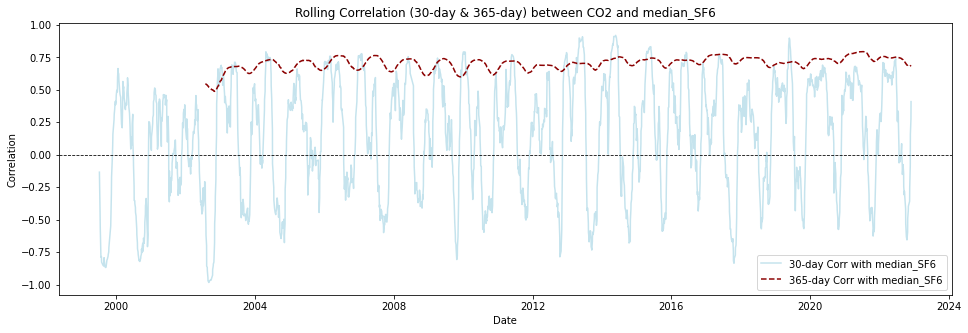

In [41]:
plot_rolling_correlations(df_combined_inner)

**Rolling correlations** (also called *moving correlations*) are a dynamic way to measure how the relationship between two variables changes over time. Unlike a single correlation coefficient that shows one number for an entire dataset, rolling correlations show how the correlation evolves throughout a time series.

Rolling correlations can be used in environmental studies to understand how relationships between variables shift with seasonal or long-term changes. 

In [42]:
# Checking for stationarity (Augmented Dickey-Fuller Test)
def check_stationarity(series, variable_name):
    result = adfuller(series.dropna())
    p_value = result[1]
    return p_value

stationarity_results = {col: check_stationarity(df_combined_inner[col], col) for col in df_combined_inner.columns}

max_lag = 12
granger_results = {}

# Performing Granger Causality tests
for col in df_combined_inner.columns:
    if col != "median_CO2":
        test_result = grangercausalitytests(df_combined_inner[['median_CO2', col]].dropna(), max_lag, verbose=False)
        granger_results[col] = {lag: test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}

stationarity_results


{'temperature': 8.363219045752621e-22,
 'humidity': 1.2650078417762235e-12,
 'dew_point': 1.1325418875804807e-19,
 'precipitation': 6.54844740791231e-20,
 'pressure': 6.803475148892472e-12,
 'evapotranspiration': 6.662669342414485e-14,
 'wind_speed': 8.122153250418046e-30,
 'soil_temperature': 1.480580933517278e-23,
 'median_CO2': 0.8630583937959493,
 'median_N2O': 0.999004879583799,
 'median_CH4': 0.6729054440779778,
 'median_SF6': 1.0}

The **ADF test** checks whether a time series data is stationary, which is crucial for many statistical analyses. A stationary time series has consistent statistical properties over time - its mean and variance don't change. 

**Granger Causality tests** explore whether past values of one variable help predict future values of another. It's testing the *"statistical causality"* - though it's important to note that Granger causality doesn't necessarily mean actual causation.

In [43]:
# Converting Granger causality test results into a readable dataFrame
granger_df = pd.DataFrame.from_dict(
    {var: [granger_results[var][lag] for lag in range(1, max_lag + 1)] for var in granger_results.keys()},
    orient='index',
    columns=[f'Lag {i}' for i in range(1, max_lag + 1)]
)

granger_df["Interpretation"] = granger_df.apply(lambda row: interpret_p_value(row.values), axis=1)
granger_df

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10,Lag 11,Lag 12,Interpretation
temperature,8.860331e-25,6.125019e-21,9.139548e-26,1.153685e-23,9.072832e-19,3.638934e-17,9.287039e-13,2.513450e-12,6.157650e-10,4.928071e-09,1.107482e-07,2.643238e-07,Strong causality (p < 0.01)
humidity,5.412154e-12,1.355012e-10,7.679884e-14,2.316054e-14,2.371246e-11,4.718695e-10,4.977062e-07,1.102951e-06,4.651620e-04,1.977284e-03,3.329687e-03,5.198356e-03,Strong causality (p < 0.01)
dew_point,5.675254e-25,3.372136e-21,6.370466e-26,2.643040e-24,1.005720e-19,3.305932e-18,1.318876e-13,6.190707e-13,4.089969e-09,3.356633e-08,1.146731e-07,2.286169e-07,Strong causality (p < 0.01)
precipitation,3.335772e-04,4.410408e-03,5.678484e-04,9.592754e-05,7.665915e-03,2.647713e-02,3.181859e-01,4.591433e-01,8.512952e-01,8.234535e-01,3.107554e-01,1.280790e-01,Moderate to low causality (p < 0.05 at some lags)
pressure,3.974949e-11,7.202753e-09,1.696877e-10,5.812546e-09,1.529336e-06,1.098885e-05,1.494581e-03,3.374869e-03,2.204412e-02,3.237441e-02,9.750331e-03,7.394630e-03,Moderate to low causality (p < 0.05 at some lags)
evapotranspiration,2.936080e-04,2.139267e-05,2.703366e-07,1.830569e-06,2.238435e-08,5.948315e-10,3.678599e-09,9.330394e-09,1.212121e-08,2.166788e-09,3.846173e-12,7.796286e-13,Strong causality (p < 0.01)
wind_speed,1.507003e-12,5.085571e-12,5.962854e-14,4.002204e-15,1.325402e-13,1.453057e-12,3.860814e-10,5.798164e-10,1.293346e-08,2.384598e-08,1.391180e-07,6.883282e-08,Strong causality (p < 0.01)
soil_temperature,4.941134e-32,2.356060e-26,1.323579e-39,2.176442e-37,1.956638e-32,1.315729e-30,6.723724e-24,2.885878e-23,4.764458e-22,6.246227e-21,8.229312e-22,3.508551e-21,Strong causality (p < 0.01)
median_N2O,8.008445e-05,4.118513e-05,8.078303e-04,6.303455e-04,1.439309e-04,3.025065e-06,1.612906e-08,1.365409e-08,6.937741e-13,4.135353e-14,9.966893e-18,1.458885e-18,Strong causality (p < 0.01)
median_CH4,6.094348e-06,1.821082e-13,1.783052e-19,2.951395e-22,2.037874e-23,3.249063e-25,1.223335e-22,4.499614e-22,6.773017e-15,8.673936e-14,5.394487e-13,1.508888e-12,Strong causality (p < 0.01)


### 1 year in the past - analysis

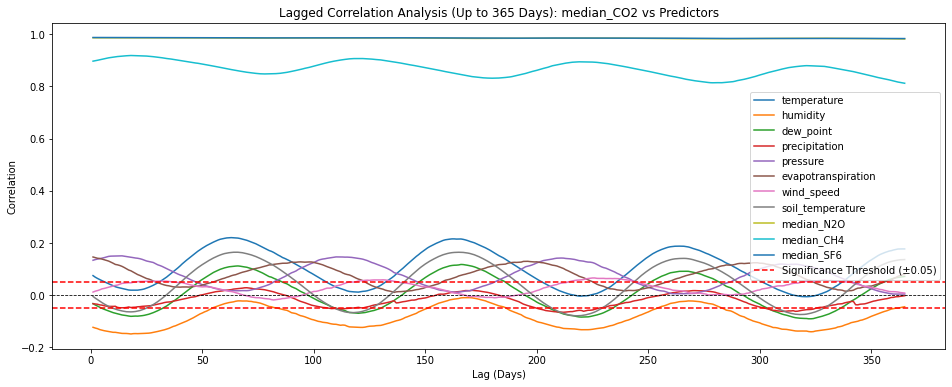

In [45]:
plot_lagged_correlations(df_combined_inner, 'median_CO2', 365)

### 5 year in the past -  analysis

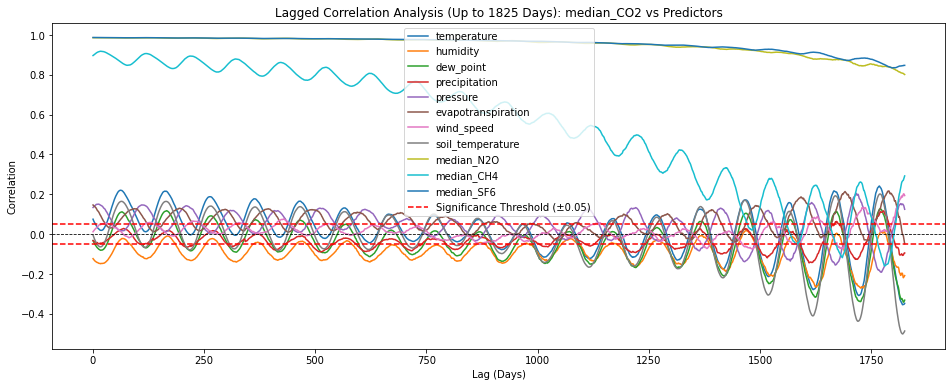

In [46]:
plot_lagged_correlations(df_combined_inner, 'median_CO2', 1825)

### 10 year back analysis

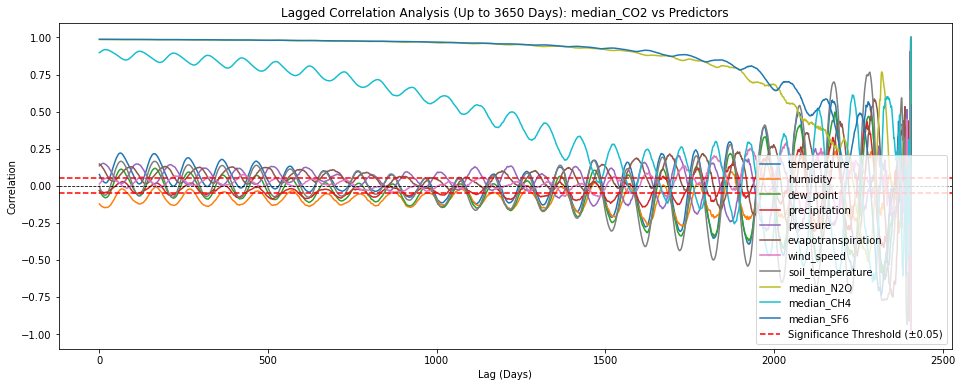

In [47]:
plot_lagged_correlations(df_combined_inner, 'median_CO2', 3650)

In [48]:
df_combined_inner.drop(columns = ['precipitation', 'wind_speed', 'dew_point', 'pressure'])

,temperature,humidity,evapotranspiration,soil_temperature,median_CO2,median_N2O,median_CH4,median_SF6
1998-11-29,27.191667,81.916667,0.152917,28.200000,366.74,315.59,1803.06,4.351
1998-12-12,26.566667,81.708333,0.155833,28.033333,367.20,315.59,1799.96,4.351
1998-12-13,26.458333,86.916667,0.124167,28.000000,367.32,315.59,1800.91,4.351
1998-12-19,25.895833,73.000000,0.170000,27.800000,367.48,315.59,1799.07,4.351
1998-12-20,26.479167,73.000000,0.150000,27.800000,367.44,315.59,1807.50,4.351
...,...,...,...,...,...,...,...,...
2022-11-13,27.200000,80.083333,0.153750,29.108333,417.25,337.65,1951.90,11.413
2022-11-19,26.841667,82.208333,0.155417,29.041667,418.38,337.01,1948.15,11.305
2022-11-20,27.712500,76.291667,0.190000,29.025000,418.48,337.93,1958.26,11.425
2022-11-26,28.012500,76.666667,0.185833,29.020833,417.81,337.02,1954.00,11.394


In [49]:
df_combined_inner.to_csv('./data/df_combined_inner.csv', index=True)

# Conclusions

## Conclusions - Descriptive Analysis

### CO<sub>2</sub> and other Greenhouse Gasses

Statistics and visualisations show that all four gasses display right-skewed distributions, reflecting **steadily rising atmospheric concentrations**; the farther the mean sits above the mode, the stronger the upward trend has been.

Most importangly and noticeably, CO₂’s slight bimodality hints at a structural shift in the record, matching the well-known *acceleration of emissions after the mid-20th century*.

Occasional high outliers in CH₄ and SF₆ (range ≫ IQR) point to *episodic emission pulses; e.g., large leaks, fires, or industrial releases.*

N₂O is the most stable series—its tight, near-symmetric distribution suggests slower, steadier increases compared with the other gases.

### CO<sub>2</sub> and Weather Data


The pairplots between CO₂ and the weather provide insights into the interrelated patterns.

First, the upper tail a.k.a. the growing concentratiosn up to 420 ppm, signal the long-term rise.

*CO₂ and. temperature* - the right slanted cloud indicates that higher air temperatures tends to coincide with higher CO₂, which means there is a mild positive linear relationship; The same logic and pattern shows weak inverse association with *relative humidity*.

*Wind* disperses CO₂ - stronger winds tilt the trend line downward, showing they dilute CO₂ locally.


## Conclusions - Correlation Analysis

### Analyzing the reson of Pearson, Kendall and Granger 

Why Pearson & Kendall Show Weak Correlation, but Granger Shows Strong Causality

The difference lies in how these methods assess relationships.

Pearson and Kendall Correlation measure instantaneous relationships between variables.

Pearson detects linear relationships at a single point in time.

Kendall identifies monotonic (rank-based) relationships, also without considering time.
These methods may miss important connections when variables affect each other with a delay — common in climate systems.

Granger Causality captures temporal dependencies.
It tests whether past values of one variable help predict future values of another.
This makes it ideal for climate data, where effects often appear gradually over weeks or months.

Examples of Delayed Causality in Climate Data

Temperature → CO₂: Rising temperatures can lead to higher CO₂ through ocean release or plant respiration, but the effect is delayed.

Humidity → CO₂: Changes in humidity impact cloud cover and soil moisture, influencing CO₂ absorption over time.

Methane → CO₂: CH₄ breaks down into CO₂, with the effect appearing months later.

Granger Causality reveals these lagged effects, while static correlations like Pearson and Kendall may overlook them.

### Analyzing Stationarity Check (<i>Augmented Dickey-Fuller Test</i>)

CO₂ (`median_C2O`) is non-stationary. This means CO₂ has a trend and may need differencing to make it stationary before modeling.
Although the meteorological data is mostly stationary, the gas related datasets (`N₂O`, `CH₄`, and `SF₆`) are non-stationary.

### Analyzing Granger Causality (<i>p-values across 1-12 lags</i>)

Lower p-values (< 0.05) indicate strong causality.
The smaller the p-value, the more significant the predictive relationship.

- **Temperature** - Strong causality across all lags - Predicts future CO₂ trends
- **Relative Humidity** - Significant up to lag 12 - Influences CO₂ levels, but weaker than temperature
- **N₂O** - Significant causality at longer lags - Has a delayed effect on CO₂
- **CH₄** Very strong causality - CH₄ changes predict CO₂ variations
- **SF₆**  Moderate causality at higher lags - SF₆ shows long-term predictive power

Temperature and CH₄ have a very strong causal effect and are the strongest predictor of CO₂

The p-values are extremely low, suggesting that past temperature values contain significant information about future CO₂ levels.

This makes sense since methane (CH₄) and CO₂ are both greenhouse gases affected by similar processes.

Humidity, N₂O, and SF₆ also predict CO₂, but to a lesser extent.

### Key Observations from 1-Year Lagged Correlation Analysis

- Temperature (temperature_2m (°C) shows a periodic pattern, with correlation peaks at approximately 90, 180, and 360 days. This indicates a seasonal influence, where earlier temperature shifts precede changes in CO₂, likely driven by vegetation cycles, ocean uptake, or energy demand patterns.

- Relative Humidity (relative_humidity_2m (%)) displays a weak but consistent negative lagged correlation. This suggests that increased humidity may lead to reduced CO₂ levels over time, potentially due to enhanced photosynthetic activity.

- N₂O (median_N2O) exhibits delayed positive correlation with CO₂. This may reflect shared industrial and combustion-related emission sources, where increases in N₂O are followed by CO₂ rises.

- CH₄ (value_CH4) shows a strong positive lagged correlation. Methane contributes to greenhouse warming and chemically converts to CO₂ in the atmosphere, explaining its predictive relationship.

- SF₆ (median_SF6) presents the most stable and persistent correlation with CO₂, indicating long-lived co-emission patterns and alignment with global industrial activity.

#### Interpretation

Temperature and methane emerge as the strongest lagged predictors of CO₂.

The observed delays, spanning from 90 to 360 days, highlight seasonal and systemic effects not captured by instantaneous correlation methods. 

Industrial gases like N₂O and SF₆ reveal longer-term trends aligned with CO₂ dynamics, while meteorological variables reflect shorter, cyclical influences.

### Key Observations from 5-Year Lagged Correlation Analysis

- Temperature (temperature_2m (°C) displays strong multi-year periodicity, with clear peaks approximately every 365 days. This pattern reflects annual climate cycles that influence CO₂ variability through temperature-driven processes.

- Relative Humidity (relative_humidity_2m (%)) exhibits an inverse cyclical pattern relative to temperature. The negative correlation suggests that higher humidity is associated with lower future CO₂ levels, potentially due to enhanced vegetation uptake and precipitation-related processes.

- CH₄ (value_CH4) and SF₆ (median_SF6) maintain consistently strong positive correlations over multiple years, indicating stable long-term relationships with CO₂, likely driven by common emission sources or atmospheric persistence.

- N₂O (median_N2O) shows sustained long-term correlation with CO₂, reflecting delayed but consistent influence, possibly due to overlapping industrial emission patterns.

#### Interpretation

The presence of pronounced annual cycles and persistent long-term correlations highlights the importance of incorporating seasonality and delayed effects in CO₂ forecasting models.

Both natural and anthropogenic drivers contribute to the observed lagged dynamics.

### Key Observations from 10-Year Lagged Correlation Analysis


- Temperature (temperature_2m (°C) exhibits strong annual oscillations, with clear periodic peaks every ~365 days. These patterns indicate persistent seasonal and multi-year influences on CO₂ concentrations.

- Relative Humidity (relative_humidity_2m (%)) shows an inverse correlation to temperature over time. The negative relationship suggests that increased humidity leads to lower future CO₂, likely due to enhanced vegetation growth, precipitation, and natural carbon sink activity.

- N₂O (median_N2O) and SF₆ (median_SF6) maintain stable, positive correlations with CO₂ across several years, indicating long-term alignment through shared industrial emission sources and slow atmospheric accumulation.

- CH₄ (value_CH4) displays strong correlation in the short to medium term, with a gradual decline beyond the first few years. This suggests a diminishing influence on CO₂ over longer horizons.

- Beyond 2,500–3,500 days (7–10 years), correlations across all variables become less stable and more variable. This may reflect the influence of external factors such as climate shifts, regulatory changes, or model limitations at extended time scales.

#### Interpretation
Annual cycles remain clearly evident and should be incorporated into long-term CO₂ forecasting models.

Humidity exerts a delayed inverse influence, potentially linked to its role in regulating carbon sinks.

Industrial gases, particularly CH₄, N₂O, and SF₆, are more relevant for mid-term prediction horizons (1–5 years), while longer-term variability introduces additional uncertainty.

# [Continue to Prediction Models 🔗](./models.ipynb)

Prediction models were developed based on this data and can be explored in the other notebook.